In [1]:
"""
# 자동완성 추천 RNN 학습하기
#-----------------------------------
# 자연어 처리나 음성처리 분야에 많이 사용되는 RNN의 기본적인 사용법을 익혀 봄.
# 4글자를 가진 단어를 학습시켜, 3글자만 주어지면, 나머지 1글자는 추천하여 단어를
# 완성하는 프로그램.
#
#"""
print(__doc__)


# 자동완성 추천 RNN 학습하기
#-----------------------------------
# 자연어 처리나 음성처리 분야에 많이 사용되는 RNN의 기본적인 사용법을 익혀 봄.
# 4글자를 가진 단어를 학습시켜, 3글자만 주어지면, 나머지 1글자는 추천하여 단어를
# 완성하는 프로그램.
#
#


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
num_dic = { cha : i for i, cha in enumerate('abcdefghijklmnopqrstuvwxyz')}
chars = list(num_dic.keys())
dic_len = len(num_dic)          # 26 개의 알파벳 글자

26

In [4]:
seq_data = [
        'word', 'wood', 'deep', 'dive', 'cold', 
        'cool', 'load', 'love', 'kiss', 'kind',
        'this', 'that', 'then', 'toss', 'tang',
        'many', 'mass', 'moss', 'mole', 'most',
        'tail', 'toll', 'test', 'tone', 'tear',
        'boss', 'bear', 'boot', 'bone', 'bits',
        'beer', 'cost', 'dust', 'doll', 'dead',
        'pear', 'pist', 'post', 'poll', 'pill'
    ]

len(seq_data)                  # 10개의 학습갯수

40

In [17]:
n_step = 3                     # 타입스텝: [1 2 3] => 3 ... 시퀀스의 갯수.
n_input = n_class = dic_len    # 알파벳 26글자
n_hidden = 128                 # 히든 레이어의 갯수 = 128개

In [6]:
def make_batch(seq_data):
    input_batch = []
    target_batch = []

    for seq in seq_data:
        input = [num_dic[n] for n in seq[:-1]]
        target = num_dic[seq[-1]]
        input_batch.append(np.eye(dic_len)[input])
        target_batch.append(target)

    return input_batch, target_batch

In [7]:
input_batch, target_batch = make_batch(seq_data)

input_batch         # [3,26] ... 2차원 리스트
type(input_batch)   # list

list

In [8]:
""" Y = WX + b [None] = [None, 3, 26].[128, 26] + [26] """
X = tf.placeholder(tf.float32, [None, n_step, n_input])
Y = tf.placeholder(tf.int32, [None])

W = tf.Variable(tf.random_normal([n_hidden, n_class]))  # [128, 26]
b = tf.Variable(tf.random_normal([n_class]))            # [128]

In [9]:
# RNN 셀을 생성합니다.
# 과적합 방지를 위한 Dropout 기법을 사용합니다.
# 여러개의 셀을 조합해서 사용하기 위해 셀을 추가로 생성합니다.
# 여러개의 셀을 조합한 RNN 셀을 생성합니다.

# tf.nn.dynamic_rnn 함수를 이용해 순환 신경망을 만듭니다. time_major=True
# 최종 결과는 one-hot 인코딩 형식으로 만듭니다

cell1 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
cell1 = tf.nn.rnn_cell.DropoutWrapper(cell1, output_keep_prob=0.5)
cell2 = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)
multi_cell = tf.nn.rnn_cell.MultiRNNCell([cell1, cell2])
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)

outputs = tf.transpose(outputs, [1, 0, 2])
outputs = outputs[-1]
model = tf.matmul(outputs, W) + b

cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=model, labels=Y))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

최적화 완료!, cost = 5.05 %


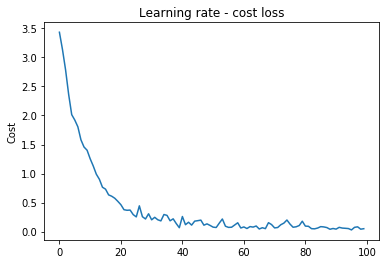

In [43]:
#########
# 신경망 모델 학습
######
learning_rate = 0.002
total_epoch = 100

sess = tf.Session()
sess.run(tf.global_variables_initializer())

dots = []
for epoch in range(total_epoch):
    _, loss = sess.run([optimizer, cost],
                       feed_dict={X: input_batch, Y: target_batch})

    #print('Epoch:', '%04d' % (epoch + 1),
    #      'cost =', '{:.6f}'.format(loss))
    dots.append(loss)
    
print('최적화 완료!, cost = {:.2f} %'.format(loss*100))


plt.title('Learning rate - cost loss')
plt.plot(dots)
plt.ylabel('Cost')
plt.show()

In [12]:
#########
# 결과 확인
######
# 레이블값이 정수이므로 예측값도 정수로 변경해줍니다.
# one-hot 인코딩이 아니므로 입력값을 그대로 비교합니다.

prediction = tf.cast(tf.argmax(model, 1), tf.int32)
prediction_check = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(prediction_check, tf.float32))

input_batch, target_batch = make_batch(seq_data)

predict, accuracy_val = sess.run([prediction, accuracy],
                                 feed_dict={X: input_batch, Y: target_batch})

predict_words = []

for idx, val in enumerate(seq_data):
    last_char = chars[predict[idx]]
    predict_words.append(val[:3] + last_char)

print('\n=== 예측 결과 ===')
print('입력값:', [w[:3] + ' ' for w in seq_data])
print('예측값:', predict_words)
print('정확도:', accuracy_val)



=== 예측 결과 ===
입력값: ['wor ', 'woo ', 'dee ', 'div ', 'col ', 'coo ', 'loa ', 'lov ', 'kis ', 'kin ', 'thi ', 'tha ', 'the ', 'tos ', 'tan ', 'man ', 'mas ', 'mos ', 'mol ', 'mos ', 'tai ', 'tol ', 'tes ', 'ton ', 'tea ', 'bos ', 'bea ', 'boo ', 'bon ', 'bit ', 'bee ', 'cos ', 'dus ', 'dol ', 'dea ', 'pea ', 'pis ', 'pos ', 'pol ', 'pil ']
예측값: ['word', 'wood', 'deep', 'dive', 'cold', 'cool', 'load', 'love', 'kiss', 'kind', 'this', 'that', 'then', 'toss', 'tang', 'many', 'mass', 'moss', 'mole', 'most', 'tail', 'toll', 'test', 'tone', 'tear', 'boss', 'bear', 'boot', 'bone', 'bits', 'beer', 'cost', 'dust', 'doll', 'dead', 'pear', 'pist', 'post', 'poll', 'pill']
정확도: 1.0
